In [2]:
import os
import requests
import torch
import json

from utils import load_local_vision_dataset, TorchDataset, convert_tensor_to_base64, convert_to_base64
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose

from dotenv import load_dotenv

load_dotenv()

True

In [3]:
ENDPOINT = "https://customvision-dev-aoai.openai.azure.com"
DEPLOYMENT_NAME = "gpt4o-001"
URL = f"{ENDPOINT}/openai/deployments/{
    DEPLOYMENT_NAME}/chat/completions?api-version=2024-02-15-preview"

HEADERS = {'api-key': os.getenv("AZURE_OPENAI_API_KEY"),
           'Content-Type': 'application/json'}

In [4]:
dataset_name = "mppd_ad_metal_plate"
dataset = load_local_vision_dataset(dataset_name=dataset_name,
                                    dataset_config_path="./datasets.json",
                                    root_dir="./",
                                    task_type="object_detection",
                                    )


transform = Compose([ToTensor()])

dataset = TorchDataset(dataset, transform=transform)
print(len(dataset))
sample_img, sample_tgt = dataset[0]
# print(sample_img)
print(sample_tgt)

97
tensor([[ 0., -1., -1., -1., -1.]])


-1.0 -1.0 -1.0 -1.0
-1024.0 -1024.0 0.0 0.0


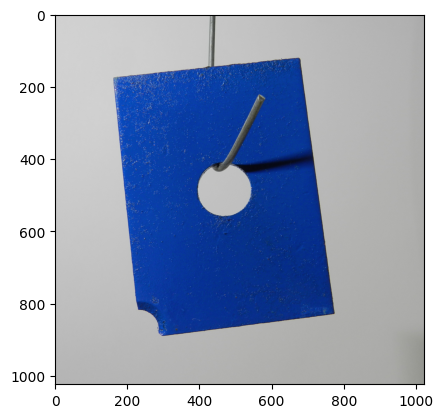

In [5]:
# Sanity check

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Convert the tensor image to numpy array
sample_img_np = sample_img.permute(1, 2, 0).numpy()

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(sample_img_np)

# Extract the bounding box coordinates
x_top, y_top, x_bottom, y_bottom = sample_tgt[0][1:].tolist()

print(x_top, y_top, x_bottom, y_bottom)


# Calculate the width and height of the bounding box
width = (x_bottom - x_top) * sample_img_np.shape[1]
height = (y_bottom - y_top) * sample_img_np.shape[0]

x_top *= sample_img_np.shape[1]
y_top *= sample_img_np.shape[0]

print(x_top, y_top, width, height)

# Create a rectangle patch
rect = patches.Rectangle((x_top, y_top), width, height, linewidth=2, edgecolor='r', facecolor='none')

# Add the rectangle patch to the axes
ax.add_patch(rect)

# Show the plot
plt.show()

In [239]:
# # Load prompt 

# with open("prompt_registry.json", "r") as f:
#     prompt_registry = json.load(f)
    
# prompt_registry

In [240]:
# prompt = prompt_registry['3']
# prompt

In [241]:
prompt = """You are an expert visual inspector for a manufacturing company that makes metal plates. You will be shown a close-up image of a metal plate and your task is to identify if it is defective or not. Think step-by-step - first identify if there is a defect or not. Second, if there is a defect, identify the type of defect. **IF** present, the defect can only be of the following types: 1.rusting, 2.scratches. Third, explain your reasoning for the defect if present. Finally, identify where the defect is located in the image and provide the relative coordinates (between 0-1) of the bounding box enclosing the defect in the format [x_top, y_top, x_bottom, y_bottom]. Please return your response **strictly** as a valid JSON object with the following format:
{"is_defective": "<yes or no>",
"reason": "<describe the defect. leave empty if is_defective is no>",
"defect_type": "<type of defect. leave empty if is_defective is no>",
"bounding_box": "[x_top, y_top, x_bottom, y_bottom]. leave empty if is_defective is no"}

Note: If  there is no defect or if you are unsure, please return "is_defective": "no" and leave the other fields empty.
"""

prompt

'You are an expert visual inspector for a manufacturing company that makes metal plates. You will be shown a close-up image of a metal plate and your task is to identify if it is defective or not. Think step-by-step - first identify if there is a defect or not. Second, if there is a defect, identify the type of defect. **IF** present, the defect can only be of the following types: 1.rusting, 2.scratches. Third, explain your reasoning for the defect if present. Finally, identify where the defect is located in the image and provide the relative coordinates (between 0-1) of the bounding box enclosing the defect in the format [x_top, y_top, x_bottom, y_bottom]. Please return your response **strictly** as a valid JSON object with the following format:\n{"is_defective": "<yes or no>",\n"reason": "<describe the defect. leave empty if is_defective is no>",\n"defect_type": "<type of defect. leave empty if is_defective is no>",\n"bounding_box": "[x_top, y_top, x_bottom, y_bottom]. leave empty if

In [242]:
context_prompt = """To help you evaluate the first image, here is a close-up reference image of a similar non-defective metal plate. Compare every part of the metal plate in the first image with the non-defective metal plate to identify any defects. Explain in your reasoning how the two images differ and what you think is the defect in the first image."""

In [243]:
# # Save prompt to a registry
# import os

# if os.path.getsize("prompt_registry.json") > 0:
#     with open("prompt_registry.json", "r") as f:
#         prompt_registry = json.load(f)
#         last_idx = max(map(int, prompt_registry.keys()))
#         prompt_registry[last_idx + 1] = prompt
# else:
#     prompt_registry = {}
#     prompt_registry[0] = prompt
    
# # Save the updated prompt registry
# with open("prompt_registry.json", "w") as f:
#     json.dump(prompt_registry, f)
    

In [244]:
def get_request_body(prompt, base64_image, context_prompt, context_base64_image):
    request_body = {
        "messages": [
            {
                "role": "system",
                "content": "You are a helpful assistant."
            },
            {
                "role": "user",
                "content": [
                        {
                            "type": "text",
                            "text": f"{prompt}"
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": "data:image/png;base64," + f"{base64_image}",
                            }
                        },
                        {
                            "type": "text",
                            "text": f"{context_prompt}"
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": "data:image/png;base64," + f"{context_base64_image}",
                            }
                        }
                ]
            }
        ],
        "max_tokens": 300
    }

    return request_body


# Sanity check
# prompt = "What is this object?"
# base64_image = convert_tensor_to_base64(sample_img)
# request_body = get_request_body(prompt, base64_image)
# print(request_body)

In [245]:
print(prompt)
print(context_prompt)

You are an expert visual inspector for a manufacturing company that makes metal plates. You will be shown a close-up image of a metal plate and your task is to identify if it is defective or not. Think step-by-step - first identify if there is a defect or not. Second, if there is a defect, identify the type of defect. **IF** present, the defect can only be of the following types: 1.rusting, 2.scratches. Third, explain your reasoning for the defect if present. Finally, identify where the defect is located in the image and provide the relative coordinates (between 0-1) of the bounding box enclosing the defect in the format [x_top, y_top, x_bottom, y_bottom]. Please return your response **strictly** as a valid JSON object with the following format:
{"is_defective": "<yes or no>",
"reason": "<describe the defect. leave empty if is_defective is no>",
"defect_type": "<type of defect. leave empty if is_defective is no>",
"bounding_box": "[x_top, y_top, x_bottom, y_bottom]. leave empty if is_d

In [246]:
import time
import random
random.seed(42)

responses = []

for sample_idx in range(0, len(dataset)):
    print(f"Processing sample {sample_idx}...")
    
    sample_img, sample_tgt = dataset[sample_idx]
    base64_image = convert_tensor_to_base64(sample_img)
    
    random_context_idx = random.randint(0, 20)
    context_sample_img, _ = dataset[random_context_idx]
    context_base64_image = convert_tensor_to_base64(context_sample_img)
    

    request_body = get_request_body(prompt, base64_image, context_prompt, context_base64_image)

    response = requests.post(URL, headers=HEADERS,
                             json=request_body, timeout=120)
    
    
    responses.append({"sample_idx": sample_idx,
                    "response": response.json()["choices"][0]["message"]["content"],
                    "target": sample_tgt.tolist()})
    
    # Wait for 20 seconds
    time.sleep(30)
    
    # break
    

# responses

Processing sample 0...
Processing sample 1...
Processing sample 2...
Processing sample 3...
Processing sample 4...
Processing sample 5...
Processing sample 6...
Processing sample 7...
Processing sample 8...
Processing sample 9...
Processing sample 10...
Processing sample 11...
Processing sample 12...
Processing sample 13...
Processing sample 14...
Processing sample 15...
Processing sample 16...
Processing sample 17...
Processing sample 18...
Processing sample 19...
Processing sample 20...
Processing sample 21...
Processing sample 22...
Processing sample 23...
Processing sample 24...
Processing sample 25...
Processing sample 26...
Processing sample 27...
Processing sample 28...
Processing sample 29...
Processing sample 30...
Processing sample 31...
Processing sample 32...
Processing sample 33...
Processing sample 34...
Processing sample 35...
Processing sample 36...
Processing sample 37...
Processing sample 38...
Processing sample 39...
Processing sample 40...
Processing sample 41...
Pr

In [248]:
response.json()

{'choices': [{'content_filter_results': {'hate': {'filtered': False,
     'severity': 'safe'},
    'self_harm': {'filtered': False, 'severity': 'safe'},
    'sexual': {'filtered': False, 'severity': 'safe'},
    'violence': {'filtered': False, 'severity': 'safe'}},
   'finish_reason': 'stop',
   'index': 0,
   'logprobs': None,
   'message': {'content': '{\n  "is_defective": "yes",\n  "reason": "The metal plate in the first image shows significant rusting on the right side, which is not present in the reference non-defective metal plate. The rusting covers a significant portion of the right side of the plate.",\n  "defect_type": "rusting",\n  "bounding_box": "[0.5, 0.2, 1.0, 0.8]"\n}',
    'role': 'assistant'}}],
 'created': 1720811190,
 'id': 'chatcmpl-9kFt8vBZqoVV4eDlTSJ2KisJTjySG',
 'model': 'gpt-4o-2024-05-13',
 'object': 'chat.completion',
 'prompt_filter_results': [{'prompt_index': 0,
   'content_filter_result': {'jailbreak': {'filtered': False,
     'detected': False},
    'cust

In [249]:
responses

[{'sample_idx': 0,
  'response': '{\n  "is_defective": "yes",\n  "reason": "The first image shows rust spots, which are not present in the reference image. These rust patches indicate corrosion.",\n  "defect_type": "rusting",\n  "bounding_box": "[0.0, 0.0, 0.5, 0.5]"\n}',
  'target': [[0.0, -1.0, -1.0, -1.0, -1.0]]},
 {'sample_idx': 1,
  'response': '```json\n{\n  "is_defective": "yes",\n  "reason": "The first metal plate has visible rusting along the left edge. The reference plate does not have this issue.",\n  "defect_type": "rusting",\n  "bounding_box": "[0.0, 0.2, 0.3, 0.8]"\n}\n```',
  'target': [[0.0, -1.0, -1.0, -1.0, -1.0]]},
 {'sample_idx': 2,
  'response': '```json\n{\n  "is_defective": "yes",\n  "reason": "There is a scratch on the metal plate.",\n  "defect_type": "scratches",\n  "bounding_box": "[0.4, 0.4, 0.6, 0.6]"\n}\n```',
  'target': [[0.0, -1.0, -1.0, -1.0, -1.0]]},
 {'sample_idx': 3,
  'response': '{\n  "is_defective": "no",\n  "reason": "",\n  "defect_type": "",\n  

In [250]:
def extract_valid_json(response):
    try:
        response = json.loads(response)
        return response
    except:
        if response.startswith("```json\n"):
            response = response.replace("```json\n", "")
            response = response.replace("\n```", "")
            response = json.loads(response)
            return response
        else:
            return "Invalid JSON"
        
# Sanity check
# sample_response = responses[0]["response"]
# print(extract_valid_json(sample_response))
            

In [251]:
for response in responses:
    response["parsed_response"] = extract_valid_json(response["response"])
    if response["parsed_response"] == "Invalid JSON":
        print(response["response"])
        print(response["parsed_response"])
        print(response["sample_idx"])
        print(response["target"])
        print("\n")
    
    

In [252]:
responses

[{'sample_idx': 0,
  'response': '{\n  "is_defective": "yes",\n  "reason": "The first image shows rust spots, which are not present in the reference image. These rust patches indicate corrosion.",\n  "defect_type": "rusting",\n  "bounding_box": "[0.0, 0.0, 0.5, 0.5]"\n}',
  'target': [[0.0, -1.0, -1.0, -1.0, -1.0]],
  'parsed_response': {'is_defective': 'yes',
   'reason': 'The first image shows rust spots, which are not present in the reference image. These rust patches indicate corrosion.',
   'defect_type': 'rusting',
   'bounding_box': '[0.0, 0.0, 0.5, 0.5]'}},
 {'sample_idx': 1,
  'response': '```json\n{\n  "is_defective": "yes",\n  "reason": "The first metal plate has visible rusting along the left edge. The reference plate does not have this issue.",\n  "defect_type": "rusting",\n  "bounding_box": "[0.0, 0.2, 0.3, 0.8]"\n}\n```',
  'target': [[0.0, -1.0, -1.0, -1.0, -1.0]],
  'parsed_response': {'is_defective': 'yes',
   'reason': 'The first metal plate has visible rusting along

In [253]:
def calculate_accuracy(responses):
    correct = 0
    for item in responses:
        response = item["parsed_response"]
        target = item["target"][0]
        
        if target == 0 and response["is_defective"] == "no":
            pass
            # correct += 1
        elif target != 0 and response["is_defective"] == "yes":
            correct += 1
            
    return correct / len(responses)


calculate_accuracy(responses)

0.9484536082474226

In [254]:
# Save responses

with open(f"{dataset_name}_responses_in_context.json", "w") as f:
    json.dump(responses, f)

In [ ]:
### One off evaluation

In [ ]:
sample_img, sample_tgt = dataset[37]
print(sample_tgt)

base64_image = convert_tensor_to_base64(sample_img)

request_body = get_request_body(prompt, base64_image)

response = requests.post(URL, headers=HEADERS,
                             json=request_body, timeout=120)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Convert the tensor image to numpy array
sample_img_np = sample_img.permute(1, 2, 0).numpy()

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(sample_img_np)

# Extract the bounding box coordinates
x_top, y_top, x_bottom, y_bottom = sample_tgt[0][1:].tolist()

# Calculate the width and height of the bounding box
width = (x_bottom - x_top) * sample_img_np.shape[1]
height = (y_bottom - y_top) * sample_img_np.shape[0]

x_top *= sample_img_np.shape[1]
y_top *= sample_img_np.shape[0]

# Create a rectangle patch
rect = patches.Rectangle((x_top, y_top), width, height, linewidth=2, edgecolor='r', facecolor='none')

# Add the rectangle patch to the axes
ax.add_patch(rect)

# Show the plot
plt.show()

In [ ]:
response.json()